# Transposed data: gradients in the time dimension
Reduced voxels

In [59]:
import numpy as np
from pathlib import Path
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
import hyppo
from graspy.plot import heatmap, pairplot

import sys
from collections import defaultdict

sys.path.append("../")
from src.tools.utils import get_files, get_latents, get_h5

%load_ext autoreload
%autoreload 2
%load_ext nb_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [7]:
## Define paths, get raw
base_dir = Path("/mnt/ssd3/ronan/data/gcca_07-06-12:32_min_rank_ZG3_transpose/")
# base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-17-18:27_max_rank-ZG2/")
groups, labels, subjs = get_latents(base_dir, flag="_gcca", ids=True)

<IPython.core.display.Javascript object>

In [8]:
labels

[['e', 'restingstate'],
 ['e', 'openmonitoring'],
 ['e', 'compassion'],
 ['n', 'restingstate'],
 ['n', 'openmonitoring'],
 ['n', 'compassion']]

<IPython.core.display.Javascript object>

In [9]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
label_transform = {
    "e": "Expert",
    "n": "Novice",
    "compassion": "Compasson",
    "restingstate": "Resting",
    "openmonitoring": "Open",
}
y_labels = [[a, b] for a, b in y]
state_labels = [b for _, b in y]
trait_labels = [a for a, _ in y]

<IPython.core.display.Javascript object>

In [13]:
groups[0][0].shape

(300, 3)

<IPython.core.display.Javascript object>

In [36]:
X = np.concatenate([np.stack(g) for g in groups])

<IPython.core.display.Javascript object>

In [37]:
X.shape

(218, 300, 3)

<IPython.core.display.Javascript object>

In [52]:
X = np.stack([np.mean(np.stack(g), axis=0) for g in groups])

<IPython.core.display.Javascript object>

In [53]:
X.shape

(6, 300, 3)

<IPython.core.display.Javascript object>

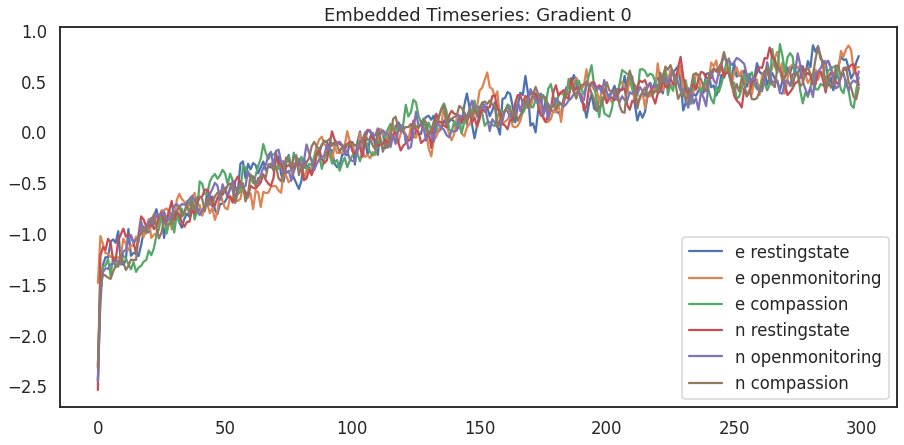

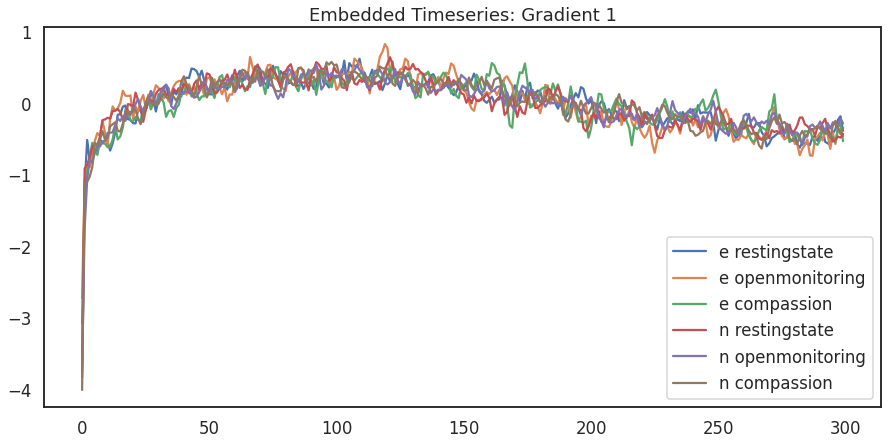

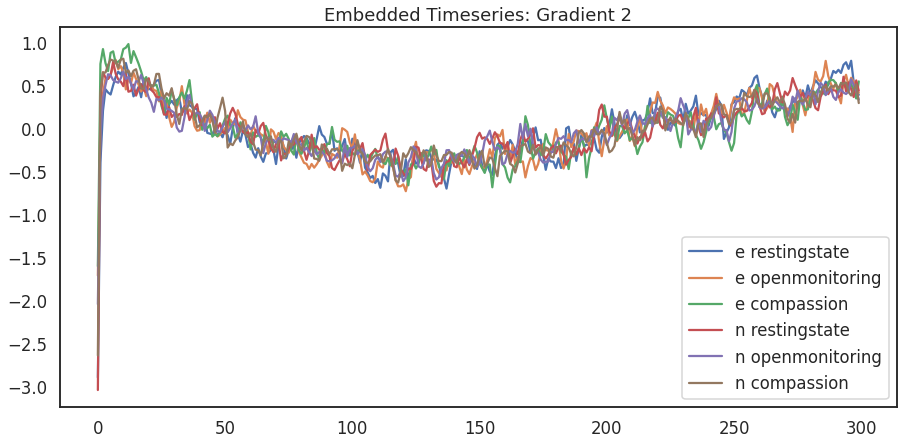

<IPython.core.display.Javascript object>

In [55]:
for grad in range(X.shape[-1]):
    f = plt.figure(figsize=(15, 7))
    for i in range(X.shape[0]):
        plt.plot(np.arange(300), X[i, :, grad], label=" ".join(labels[i]))
    plt.legend()
    plt.title(f"Embedded Timeseries: Gradient {grad}")
    plt.show()

## Plot loadings

In [56]:
from nilearn import datasets, plotting
import nibabel as nib
import matplotlib as mpl

<IPython.core.display.Javascript object>

In [57]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()
external_dir = Path("../data/external")


def visualize_embeddings(
    embeddings,
    save_path=False,
    vmax=None,
    symmetric_cbar=True,
    colorbar=False,
    n_embed=1,
    title=None,
):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(
        n_embed,
        4,
        subplot_kw={"projection": "3d"},
        figsize=(res_scale * 5, res_scale * n_embed),
    )
    if n_embed == 1:
        axes = [axes]

    plt.subplots_adjust(wspace=0, hspace=0)

    for i, ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(external_dir / "lh.cortex.label")

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[: len(cortex_left)]

        plotting.plot_surf_stat_map(
            fsa5.infl_left,
            conn_map,
            hemi="left",
            colorbar=False,
            cmap="RdBu",
            axes=ax[0],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        plotting.plot_surf_stat_map(
            fsa5.infl_left,
            conn_map,
            hemi="left",
            colorbar=False,
            cmap="RdBu",
            view="medial",
            axes=ax[1],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        cortex_right = nib.freesurfer.read_label(external_dir / "rh.cortex.label")

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left) :]

        plotting.plot_surf_stat_map(
            fsa5.infl_right,
            conn_map,
            hemi="right",
            colorbar=False,
            cmap="RdBu",
            axes=ax[2],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        plotting.plot_surf_stat_map(
            fsa5.infl_right,
            conn_map,
            hemi="right",
            colorbar=colorbar,
            cmap="RdBu",
            view="medial",
            axes=ax[3],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

    if title:
        fig.suptitle(title, fontsize=20, y=0.92)
    if save_path:
        plt.savefig(f"{str(save_path)}.png", format="png", bbox_inches="tight")
    else:
        return fig


#         plt.show()
#         plt.close(fig)


def make_cbar(vmax, save_path=None, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu
    else:
        cmap = mpl.cm.Blues
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    # cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="vertical")

    # cb1.set_clim(vmin, vmax)
    # cb1.set_label('Some Units')
    if save_path:
        plt.savefig(f"{str(save_path)}.pdf", bbox_inches="tight")
    plt.close(fig)

<IPython.core.display.Javascript object>

In [ ]:
## Define paths, get raw
base_dir = Path("/mnt/ssd3/ronan/data/gcca_07-06-14:06_min_rank_ZG3_transpose/")
# base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-17-18:27_max_rank-ZG2/")
data_dict = get_h5(base_dir, flag="_gcca")

In [ ]:
data_dict.keys()

In [ ]:
subjs = data_dict["subject"]
states = data_dict["state"]
traits = data_dict["trait"]
loadings = np.asarray(data_dict["projection"])

In [ ]:
group_labels = np.asarray([[t, s] for t, s in zip(traits, states)])
groups = np.unique(group_labels, axis=0)

In [ ]:
group_labels = np.asarray([[t, s] for t, s in zip(traits, states)])
groups = np.unique(group_labels, axis=0)

In [ ]:
vmax = None#max([np.max(np.abs(g)) for g in means])
SAVE = False
COLORBAR = True

for name, mean in zip(groups, means):
    if SAVE:
        title = False
    else:
        title = " ".join(name)
    visualize_embeddings(
        mean, save_path=False, colorbar=COLORBAR, n_embed=3, vmax=vmax, title=title,
    )

    if SAVE:
        # plt.savefig(save_dir / f"{name}_sig_diff_gradients.pdf", bbox_inches="tight")
        plt.show()
    else:
        plt.show()

# if SAVE and not COLORBAR:
#     make_cbar(vmax, save_dir / "sig_diffs_gradients_colorbar")